In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv', parse_dates=['Date'], index_col='Date')
data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']]

In [3]:
# Normalize data using 'Adj Close'
data_mean = data.mean()
data_std = data.std()
data_normalized = (data - data_mean) / data_std

In [4]:
# Prepare dataset using 'Adj Close' for the target
class StockDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data.values
        self.window_size = window_size
        self.samples = []
        for i in range(len(data) - window_size):
            self.samples.append((self.data[i:i+window_size], self.data[i+window_size, 5]))  # Predicting 'Adj Close' price

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X, y = self.samples[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [5]:
window_size = 30
dataset = StockDataset(data_normalized, window_size)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
# Step 2: Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=16, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                    num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 64)
        self.fc_2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.relu(output[:, -1, :])
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        return out

In [7]:
input_size = data_normalized.shape[-1]
lstm_model = LSTM(input_size=input_size)

# Step 3: Train the model
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [8]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    return train_losses

train_losses = train_model(lstm_model, train_loader, criterion, optimizer)

Epoch 1/10, Loss: 0.3378
Epoch 2/10, Loss: 0.0037
Epoch 3/10, Loss: 0.0023
Epoch 4/10, Loss: 0.0018
Epoch 5/10, Loss: 0.0014
Epoch 6/10, Loss: 0.0015
Epoch 7/10, Loss: 0.0015
Epoch 8/10, Loss: 0.0013
Epoch 9/10, Loss: 0.0011
Epoch 10/10, Loss: 0.0013


In [9]:
# Step 4: Evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    predictions, actuals = [], []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item() * inputs.size(0)
            predictions.extend(outputs.squeeze().cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    test_loss /= len(test_loader.dataset)
    return predictions, actuals, test_loss

lstm_predictions, lstm_actuals, lstm_test_loss = evaluate_model(lstm_model, test_loader, criterion)

In [10]:
# Step 5: Convert back to original scale using 'Adj Close'
def inverse_transform(predictions, data_mean, data_std, feature_index=5):
    predictions = torch.tensor(predictions)
    return (predictions * data_std[feature_index]) + data_mean[feature_index]

lstm_predictions = inverse_transform(lstm_predictions, data_mean, data_std)
lstm_actuals = inverse_transform(lstm_actuals, data_mean, data_std)

# Get the corresponding dates for the test set
test_dates = data.index[-test_size:]

In [11]:
# Step 6: Define the xLSTM model
class sLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(sLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size * 4)
        self.h2h = nn.Linear(hidden_size, hidden_size * 4)

        self.normalizer = nn.Parameter(torch.zeros(hidden_size))
        self.stabilizer = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, hidden):
        h, c, n, m = hidden

        gates = self.i2h(x) + self.h2h(h)
        z, i_tilde, f_tilde, o = torch.chunk(gates, 4, dim=1)

        i = torch.exp(i_tilde)
        f = torch.exp(f_tilde)
        m_next = torch.max(torch.log(f + 1e-8) + m, torch.log(i + 1e-8))
        i_stable = torch.exp(torch.log(i + 1e-8) - m_next)
        f_stable = torch.exp(torch.log(f + 1e-8) + m - m_next)

        n_next = f_stable * n + i_stable
        c_next = f_stable * c + i_stable * torch.tanh(z)

        h_tilde = c_next / n_next
        h_next = torch.sigmoid(o) * h_tilde

        return h_next, (h_next, c_next, n_next, m_next)

class mLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(mLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.Wq = nn.Linear(input_size, hidden_size)
        self.Wk = nn.Linear(input_size, hidden_size)
        self.Wv = nn.Linear(input_size, hidden_size)
        self.i2h = nn.Linear(input_size, hidden_size * 4)
        self.h2h = nn.Linear(hidden_size, hidden_size * 4)

        self.normalizer = nn.Parameter(torch.zeros(hidden_size))
        self.stabilizer = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, hidden):
        h, C, n, m = hidden

        gates = self.i2h(x) + self.h2h(h)
        z, i_tilde, f_tilde, o = torch.chunk(gates, 4, dim=1)

        i = torch.exp(i_tilde)
        f = torch.sigmoid(f_tilde)
        m_next = torch.max(torch.log(f + 1e-8) + m, torch.log(i + 1e-8))
        i_stable = torch.exp(torch.log(i + 1e-8) - m_next)
        f_stable = torch.exp(torch.log(f + 1e-8) + m - m_next)

        n_next = f_stable * n + i_stable * torch.ones_like(n)

        k_t = self.Wk(x)
        v_t = self.Wv(x)
        C_next = f_stable * C + i_stable * (v_t.unsqueeze(-1) @ k_t.unsqueeze(1))

        q_t = self.Wq(x)
        h_tilde = (C_next @ q_t.unsqueeze(-1)).squeeze(-1) / torch.clamp(torch.abs(n_next @ q_t.unsqueeze(-1).squeeze(-1)), min=1.0)

        h_next = torch.sigmoid(o) * h_tilde

        return h_next, (h_next, C_next, n_next, m_next)

class xLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, cell_type='sLSTM'):
        super(xLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList()
        for _ in range(num_layers):
            if cell_type == 'sLSTM':
                self.cells.append(sLSTMCell(input_size, hidden_size))
            else:
                self.cells.append(mLSTMCell(input_size, hidden_size))
            input_size = hidden_size

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.num_layers)]
        n = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.num_layers)]
        m = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.num_layers)]
        C = [torch.zeros(batch_size, self.hidden_size, self.hidden_size) for _ in range(self.num_layers)]  # For mLSTM

        for t in range(seq_len):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                if isinstance(self.cells[layer], sLSTMCell):
                    h[layer], (h[layer], c[layer], n[layer], m[layer]) = self.cells[layer](x_t, (h[layer], c[layer], n[layer], m[layer]))
                else:
                    h[layer], (h[layer], C[layer], n[layer], m[layer]) = self.cells[layer](x_t, (h[layer], C[layer], n[layer], m[layer]))
                x_t = h[layer]

        out = self.fc(h[-1])
        return out

In [12]:
xLSTM_model = xLSTM(input_size=input_size, hidden_size=50, num_layers=2, cell_type='sLSTM')
xLSTM_optimizer = optim.Adam(xLSTM_model.parameters(), lr=0.01)
xLSTM_train_losses = train_model(xLSTM_model, train_loader, criterion, xLSTM_optimizer)
xLSTM_predictions, xLSTM_actuals, xLSTM_test_loss = evaluate_model(xLSTM_model, test_loader, criterion)

Epoch 1/10, Loss: 0.0234
Epoch 2/10, Loss: 0.0018
Epoch 3/10, Loss: 0.0016
Epoch 4/10, Loss: 0.0014
Epoch 5/10, Loss: 0.0048
Epoch 6/10, Loss: 0.0013
Epoch 7/10, Loss: 0.0014
Epoch 8/10, Loss: 0.0020
Epoch 9/10, Loss: 0.0011
Epoch 10/10, Loss: 0.0021


In [13]:
xLSTM_predictions = inverse_transform(xLSTM_predictions, data_mean, data_std, feature_index=5)
xLSTM_actuals = inverse_transform(xLSTM_actuals, data_mean, data_std)

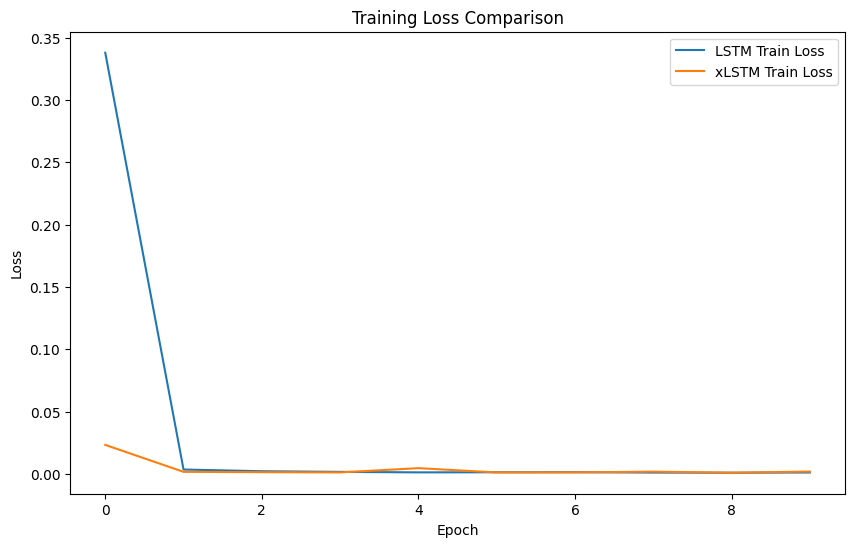

LSTM Test Loss: 0.0010
xLSTM Test Loss: 0.0011


In [14]:
# Step 7: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='LSTM Train Loss')
plt.plot(xLSTM_train_losses, label='xLSTM Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

print(f'LSTM Test Loss: {lstm_test_loss:.4f}')
print(f'xLSTM Test Loss: {xLSTM_test_loss:.4f}')

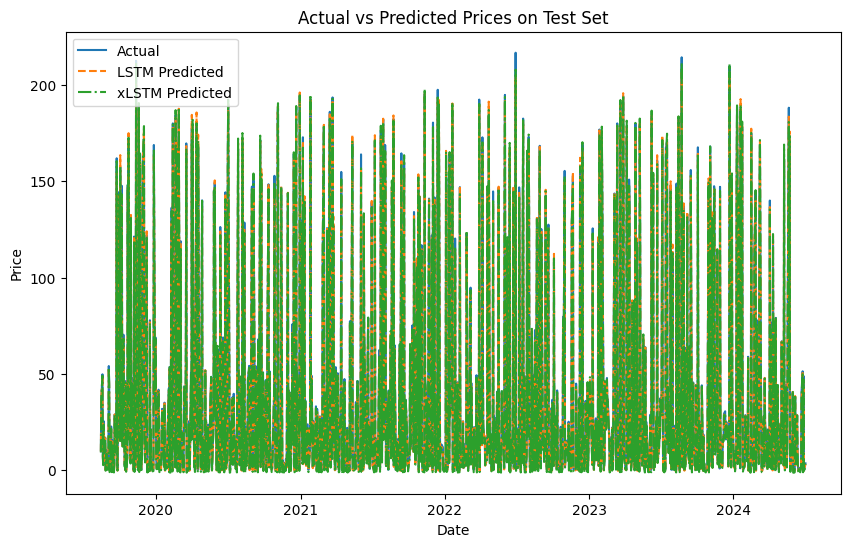

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates, lstm_actuals, label='Actual', linestyle='-')
plt.plot(test_dates, lstm_predictions, label='LSTM Predicted', linestyle='--')
plt.plot(test_dates, xLSTM_predictions, label='xLSTM Predicted', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices on Test Set')
plt.legend()
plt.show()

In [16]:
# Step 8: Predict the next 10 days
def predict_next_days(model, data_normalized, data_mean, data_std, window_size, num_days=10):
    model.eval()
    with torch.no_grad():
        last_window = data_normalized[-window_size:].values
        predictions = []
        input_data = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0)

        for _ in range(num_days):
            pred = model(input_data)
            predictions.append(pred.item())

            # Update input_data with the new prediction
            new_input = torch.tensor([last_window[-1, :-1].tolist() + [pred.item()]], dtype=torch.float32)
            input_data = torch.cat((input_data[:, 1:, :], new_input.unsqueeze(1)), dim=1)

        predictions = torch.tensor(predictions)
        predictions = inverse_transform(predictions, data_mean, data_std, feature_index=5)
        return predictions.numpy()

# Predict the next 10 days
next_10_days_predictions_lstm = predict_next_days(lstm_model, data_normalized, data_mean, data_std, window_size, num_days=10)
next_10_days_predictions_xlstm = predict_next_days(xLSTM_model, data_normalized, data_mean, data_std, window_size, num_days=10)

# Get the corresponding dates for the predictions
last_date = data.index[-1]
next_10_days_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=10, freq='B')  # Assuming business days

<ipython-input-10-5bae6d1413df>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions)


[207.76248 207.96597 208.05109 208.06036 208.02646 207.97244 207.91296
 207.8565  207.8071  207.76614]
[211.68002 208.83344 208.66544 208.7883  209.08081 209.17648 209.11566
 209.11536 209.14871 209.23563]
DatetimeIndex(['2024-07-02', '2024-07-03', '2024-07-04', '2024-07-05',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-15'],
              dtype='datetime64[ns]', freq='B')


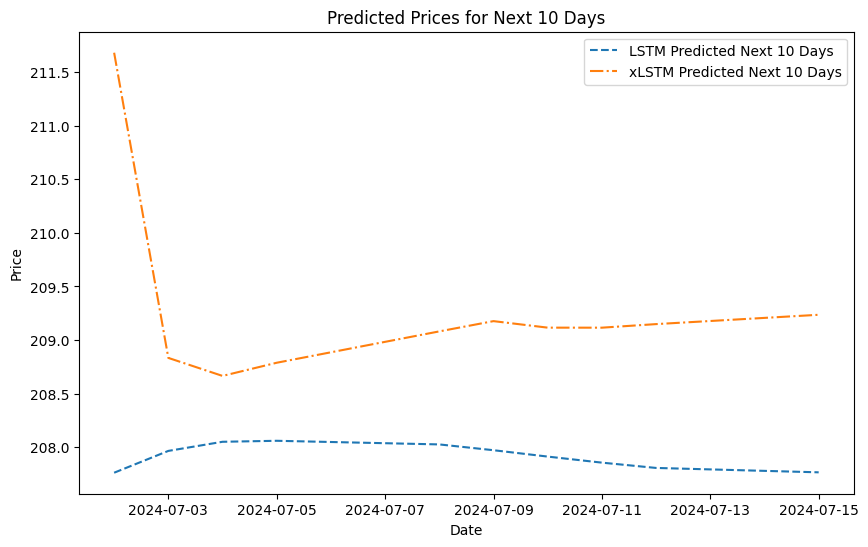

In [17]:
print(next_10_days_predictions_lstm)
print(next_10_days_predictions_xlstm)
print(next_10_days_dates)

# Visualize the next 10 days predictions
plt.figure(figsize=(10, 6))
plt.plot(next_10_days_dates, next_10_days_predictions_lstm, label='LSTM Predicted Next 10 Days', linestyle='--')
plt.plot(next_10_days_dates, next_10_days_predictions_xlstm, label='xLSTM Predicted Next 10 Days', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted Prices for Next 10 Days')
plt.legend()
plt.show()

In [18]:
import h5py

def save_model_to_h5(model, filepath):
    state_dict = model.state_dict()
    with h5py.File(filepath, 'w') as h5file:
        for key, value in state_dict.items():
            h5file.create_dataset(key, data=value.cpu().numpy())

# Save LSTM model
save_model_to_h5(lstm_model, 'lstm_model_weights.h5')

# Save xLSTM model
save_model_to_h5(xLSTM_model, 'xlstm_model_weights.h5')